In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load Data

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_path = "C:\\Users\\ramum\\Downloads\\Resources_ModelTraining_CNN\\Download files\\dataset"
dataset = datasets.ImageFolder(root = dataset_path, transform = image_transforms)
len(dataset)

2300

In [5]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [6]:
num_classes = len(dataset.classes)
num_classes

6

In [7]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

In [8]:
train_size

1725

In [9]:
val_size

575

In [10]:
from torch.utils.data import random_split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [12]:
for images, labels in train_loader:
  print(images.shape)
  print(labels.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [13]:
labels[0]

tensor(1)

In [14]:
images[0].shape

torch.Size([3, 224, 224])

In [15]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

In [16]:
#plt.imshow(images[0].permute(1,2,0))
#plt.show()

### Model 1: CNN

In [17]:
class CarClassifierCNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #(16, 16, 224)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(16, 112, 112)
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(32, 56, 56)
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), #(64, 56, 56)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(64, 28, 28)
        nn.Flatten(),
        nn.Linear(64*28*28, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )
  def forward(self, x):
    return self.network(x)

In [18]:
# Instantiate the model, loss_function and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [19]:
def train_model(model, criterion, optimizer, epochs = 5):
  start_time = time.time()
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_num, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      # Forward Poss
      outputs = model(images)
      loss = criterion(outputs, labels)
      # Backward Pass and optimization
      loss.backward()
      optimizer.step()
      if (batch_num + 1) % 10 == 0:
        print(f"Batch: {batch_num + 1}, Epoch: {epoch + 1}, Loss: {loss.item():0.2f}")
      running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"[{epoch+1}/{epochs}], Avg_Loss: {epoch_loss:.4f}")
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
      print(f"*** Validation Accuracy: {100 * correct / total: .2f}% ***")
    end_time = time.time()
    print(f"Execution time: {end_time - start_time} seconds")
  return all_labels, all_predictions

In [20]:
train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.81
Batch: 20, Epoch: 1, Loss: 1.78
Batch: 30, Epoch: 1, Loss: 1.76
Batch: 40, Epoch: 1, Loss: 1.71
Batch: 50, Epoch: 1, Loss: 1.78
[1/5], Avg_Loss: 6.1002
*** Validation Accuracy:  22.78% ***
Execution time: 146.87333464622498 seconds
Batch: 10, Epoch: 2, Loss: 1.76
Batch: 20, Epoch: 2, Loss: 1.73
Batch: 30, Epoch: 2, Loss: 1.74
Batch: 40, Epoch: 2, Loss: 1.77
Batch: 50, Epoch: 2, Loss: 1.76
[2/5], Avg_Loss: 1.7713
*** Validation Accuracy:  22.78% ***
Execution time: 291.9932310581207 seconds
Batch: 10, Epoch: 3, Loss: 1.81
Batch: 20, Epoch: 3, Loss: 1.74
Batch: 30, Epoch: 3, Loss: 1.78
Batch: 40, Epoch: 3, Loss: 1.79
Batch: 50, Epoch: 3, Loss: 1.79
[3/5], Avg_Loss: 1.7699
*** Validation Accuracy:  21.04% ***
Execution time: 437.89276480674744 seconds
Batch: 10, Epoch: 4, Loss: 1.78
Batch: 20, Epoch: 4, Loss: 1.76
Batch: 30, Epoch: 4, Loss: 1.76
Batch: 40, Epoch: 4, Loss: 1.76
Batch: 50, Epoch: 4, Loss: 1.75
[4/5], Avg_Loss: 1.7688
*** Validation Accuracy: 

([2,
  1,
  0,
  1,
  0,
  2,
  2,
  1,
  0,
  2,
  2,
  5,
  2,
  1,
  1,
  1,
  0,
  5,
  0,
  1,
  0,
  5,
  2,
  1,
  5,
  3,
  2,
  5,
  0,
  5,
  2,
  2,
  2,
  2,
  3,
  0,
  0,
  0,
  4,
  0,
  1,
  2,
  2,
  2,
  5,
  1,
  0,
  0,
  3,
  1,
  5,
  1,
  4,
  4,
  2,
  0,
  2,
  0,
  5,
  1,
  2,
  1,
  2,
  4,
  3,
  1,
  1,
  4,
  5,
  0,
  1,
  1,
  1,
  3,
  0,
  0,
  3,
  4,
  1,
  3,
  2,
  0,
  2,
  2,
  5,
  0,
  2,
  5,
  3,
  5,
  4,
  1,
  2,
  1,
  1,
  0,
  2,
  4,
  0,
  4,
  2,
  0,
  2,
  1,
  0,
  1,
  2,
  0,
  2,
  1,
  1,
  3,
  4,
  2,
  0,
  3,
  3,
  2,
  1,
  3,
  0,
  1,
  2,
  0,
  5,
  2,
  2,
  2,
  2,
  1,
  2,
  3,
  5,
  2,
  2,
  2,
  3,
  2,
  3,
  5,
  0,
  0,
  2,
  0,
  5,
  4,
  3,
  1,
  1,
  2,
  3,
  3,
  0,
  5,
  2,
  1,
  2,
  3,
  5,
  0,
  5,
  1,
  2,
  3,
  5,
  1,
  5,
  5,
  1,
  3,
  3,
  4,
  1,
  4,
  4,
  3,
  3,
  4,
  5,
  5,
  1,
  4,
  4,
  3,
  3,
  5,
  2,
  2,
  2,
  3,
  5,
  2,
  4,
  5,
  1,
  3,
  0,
  1,
  1,
  2,


### Model 2: CNN with Regularizatiion

In [21]:
class CarClassifierCNNWithRegularization(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #(16, 16, 224)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(16, 112, 112)
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(32, 56, 56)
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), #(64, 56, 56)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(64, 28, 28)
        nn.Flatten(),
        nn.Linear(64*28*28, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
  def forward(self, x):
    return self.network(x)

In [22]:
# Instantiate the model, loss_function and optimizer
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 79.79
Batch: 20, Epoch: 1, Loss: 5.18
Batch: 30, Epoch: 1, Loss: 1.88
Batch: 40, Epoch: 1, Loss: 1.75
Batch: 50, Epoch: 1, Loss: 2.09
[1/5], Avg_Loss: 56.5003
*** Validation Accuracy:  22.61% ***
Execution time: 146.6245710849762 seconds
Batch: 10, Epoch: 2, Loss: 1.77
Batch: 20, Epoch: 2, Loss: 1.77
Batch: 30, Epoch: 2, Loss: 1.81
Batch: 40, Epoch: 2, Loss: 1.78
Batch: 50, Epoch: 2, Loss: 1.74
[2/5], Avg_Loss: 1.7889
*** Validation Accuracy:  22.78% ***
Execution time: 290.0775475502014 seconds
Batch: 10, Epoch: 3, Loss: 1.80
Batch: 20, Epoch: 3, Loss: 1.81
Batch: 30, Epoch: 3, Loss: 1.72
Batch: 40, Epoch: 3, Loss: 1.82
Batch: 50, Epoch: 3, Loss: 1.76
[3/5], Avg_Loss: 1.7673
*** Validation Accuracy:  21.04% ***
Execution time: 432.5394802093506 seconds
Batch: 10, Epoch: 4, Loss: 1.72
Batch: 20, Epoch: 4, Loss: 1.75
Batch: 30, Epoch: 4, Loss: 1.76
Batch: 40, Epoch: 4, Loss: 1.73
Batch: 50, Epoch: 4, Loss: 1.83
[4/5], Avg_Loss: 1.7677
*** Validation Accuracy: 

([0,
  3,
  1,
  5,
  1,
  1,
  2,
  1,
  1,
  3,
  2,
  4,
  2,
  1,
  1,
  2,
  2,
  2,
  0,
  2,
  0,
  2,
  2,
  4,
  5,
  3,
  4,
  3,
  2,
  4,
  2,
  3,
  0,
  5,
  0,
  4,
  0,
  5,
  4,
  0,
  1,
  0,
  2,
  0,
  0,
  2,
  1,
  3,
  4,
  4,
  1,
  2,
  0,
  0,
  1,
  5,
  0,
  1,
  0,
  3,
  5,
  0,
  4,
  2,
  1,
  0,
  0,
  0,
  2,
  5,
  4,
  2,
  1,
  3,
  1,
  1,
  5,
  4,
  3,
  2,
  4,
  2,
  2,
  2,
  0,
  4,
  4,
  3,
  4,
  3,
  0,
  4,
  4,
  0,
  0,
  2,
  3,
  0,
  2,
  2,
  2,
  2,
  1,
  1,
  2,
  1,
  1,
  0,
  2,
  3,
  5,
  4,
  0,
  3,
  5,
  4,
  5,
  1,
  5,
  2,
  2,
  5,
  5,
  2,
  2,
  1,
  2,
  5,
  2,
  0,
  0,
  2,
  4,
  2,
  1,
  0,
  0,
  4,
  3,
  5,
  2,
  4,
  3,
  3,
  1,
  2,
  2,
  2,
  0,
  1,
  2,
  5,
  0,
  4,
  2,
  2,
  0,
  4,
  0,
  0,
  2,
  2,
  3,
  5,
  4,
  0,
  1,
  2,
  0,
  4,
  4,
  5,
  5,
  2,
  3,
  3,
  2,
  2,
  0,
  1,
  1,
  2,
  3,
  0,
  0,
  2,
  0,
  4,
  2,
  2,
  5,
  2,
  5,
  5,
  1,
  4,
  0,
  2,
  1,
  1,


### Model 3: Transfer Learning with EfficientNet

In [23]:
class CarClassifierEfficientNet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.model = models.efficientnet_b0(weights = 'DEFAULT')
    for param in self.model.parameters():
      param.requires_grad = False
    in_features = self.model.classifier[1].in_features
    self.model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features, num_classes)
    )
  def forward(self, x):
    return self.model(x)

In [24]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

train_model(model, criterion, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\ramum/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:03<00:00, 5.71MB/s]


Batch: 10, Epoch: 1, Loss: 1.71
Batch: 20, Epoch: 1, Loss: 1.50
Batch: 30, Epoch: 1, Loss: 1.47
Batch: 40, Epoch: 1, Loss: 1.28
Batch: 50, Epoch: 1, Loss: 1.34
[1/10], Avg_Loss: 1.4718
*** Validation Accuracy:  55.30% ***
Execution time: 147.1679801940918 seconds
Batch: 10, Epoch: 2, Loss: 1.04
Batch: 20, Epoch: 2, Loss: 1.17
Batch: 30, Epoch: 2, Loss: 1.14
Batch: 40, Epoch: 2, Loss: 1.03
Batch: 50, Epoch: 2, Loss: 0.86
[2/10], Avg_Loss: 1.1093
*** Validation Accuracy:  59.83% ***
Execution time: 295.8516752719879 seconds
Batch: 10, Epoch: 3, Loss: 0.99
Batch: 20, Epoch: 3, Loss: 1.01
Batch: 30, Epoch: 3, Loss: 1.06
Batch: 40, Epoch: 3, Loss: 0.98
Batch: 50, Epoch: 3, Loss: 1.14
[3/10], Avg_Loss: 0.9965
*** Validation Accuracy:  57.74% ***
Execution time: 447.10350370407104 seconds
Batch: 10, Epoch: 4, Loss: 0.95
Batch: 20, Epoch: 4, Loss: 1.02
Batch: 30, Epoch: 4, Loss: 0.97
Batch: 40, Epoch: 4, Loss: 1.02
Batch: 50, Epoch: 4, Loss: 0.64
[4/10], Avg_Loss: 0.9423
*** Validation Accurac

([2,
  0,
  1,
  2,
  2,
  4,
  0,
  1,
  3,
  2,
  2,
  3,
  4,
  0,
  5,
  4,
  3,
  1,
  1,
  5,
  5,
  0,
  1,
  2,
  5,
  1,
  0,
  3,
  5,
  4,
  1,
  3,
  0,
  2,
  4,
  0,
  2,
  3,
  1,
  3,
  2,
  0,
  0,
  1,
  5,
  2,
  4,
  2,
  0,
  0,
  3,
  0,
  3,
  3,
  2,
  2,
  5,
  4,
  4,
  2,
  5,
  2,
  1,
  1,
  1,
  1,
  1,
  2,
  0,
  5,
  5,
  1,
  0,
  2,
  2,
  5,
  1,
  4,
  5,
  4,
  4,
  1,
  1,
  0,
  4,
  4,
  2,
  0,
  1,
  1,
  2,
  4,
  0,
  0,
  5,
  0,
  1,
  1,
  1,
  0,
  2,
  3,
  0,
  4,
  2,
  2,
  2,
  1,
  2,
  5,
  4,
  3,
  4,
  1,
  0,
  1,
  2,
  0,
  0,
  4,
  2,
  4,
  0,
  2,
  0,
  0,
  3,
  4,
  2,
  2,
  1,
  3,
  2,
  0,
  5,
  3,
  2,
  1,
  5,
  4,
  2,
  1,
  3,
  2,
  0,
  3,
  3,
  5,
  3,
  0,
  3,
  5,
  2,
  2,
  5,
  5,
  0,
  1,
  0,
  3,
  5,
  2,
  1,
  2,
  4,
  2,
  4,
  1,
  4,
  1,
  2,
  4,
  4,
  0,
  0,
  5,
  3,
  3,
  4,
  5,
  0,
  1,
  3,
  2,
  0,
  2,
  2,
  0,
  2,
  3,
  5,
  4,
  4,
  1,
  5,
  2,
  2,
  2,
  2,
  0,


### Model 4: Transfer Learning with ResNet

In [25]:
class CarClassifierResNet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.model = models.resnet50(weights = 'DEFAULT')
    for param in self.model.parameters():
      param.requires_grad = False
    for param in self.model.layer4.parameters():
      param.requires_grad = True
    self.model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(self.model.fc.in_features, num_classes)
    )
  def forward(self, x):
    return self.model(x)

In [26]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
riterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

train_model(model, criterion, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\ramum/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:20<00:00, 4.89MB/s]


Batch: 10, Epoch: 1, Loss: 1.03
Batch: 20, Epoch: 1, Loss: 0.68
Batch: 30, Epoch: 1, Loss: 0.72
Batch: 40, Epoch: 1, Loss: 0.61
Batch: 50, Epoch: 1, Loss: 0.73
[1/10], Avg_Loss: 0.9161
*** Validation Accuracy:  65.39% ***
Execution time: 156.461749792099 seconds
Batch: 10, Epoch: 2, Loss: 0.41
Batch: 20, Epoch: 2, Loss: 0.21
Batch: 30, Epoch: 2, Loss: 0.26
Batch: 40, Epoch: 2, Loss: 0.93
Batch: 50, Epoch: 2, Loss: 0.64
[2/10], Avg_Loss: 0.4769
*** Validation Accuracy:  73.04% ***
Execution time: 314.90131974220276 seconds
Batch: 10, Epoch: 3, Loss: 0.45
Batch: 20, Epoch: 3, Loss: 0.49
Batch: 30, Epoch: 3, Loss: 0.29
Batch: 40, Epoch: 3, Loss: 0.34
Batch: 50, Epoch: 3, Loss: 0.31
[3/10], Avg_Loss: 0.3500
*** Validation Accuracy:  71.30% ***
Execution time: 471.9494082927704 seconds
Batch: 10, Epoch: 4, Loss: 0.22
Batch: 20, Epoch: 4, Loss: 0.21
Batch: 30, Epoch: 4, Loss: 0.15
Batch: 40, Epoch: 4, Loss: 0.42
Batch: 50, Epoch: 4, Loss: 0.25
[4/10], Avg_Loss: 0.2466
*** Validation Accuracy

([1,
  1,
  0,
  1,
  1,
  2,
  5,
  0,
  5,
  5,
  1,
  3,
  2,
  3,
  2,
  3,
  2,
  1,
  0,
  1,
  2,
  2,
  4,
  1,
  0,
  0,
  1,
  4,
  1,
  3,
  2,
  1,
  5,
  3,
  0,
  4,
  4,
  2,
  0,
  1,
  3,
  1,
  3,
  5,
  0,
  0,
  1,
  0,
  4,
  2,
  2,
  0,
  4,
  3,
  0,
  1,
  1,
  2,
  0,
  1,
  4,
  0,
  0,
  0,
  2,
  1,
  0,
  2,
  0,
  3,
  1,
  2,
  2,
  2,
  0,
  2,
  5,
  2,
  5,
  0,
  2,
  0,
  5,
  0,
  1,
  5,
  5,
  4,
  4,
  0,
  1,
  4,
  5,
  4,
  3,
  5,
  2,
  2,
  1,
  4,
  3,
  1,
  0,
  0,
  1,
  0,
  2,
  4,
  0,
  4,
  2,
  3,
  3,
  1,
  1,
  5,
  5,
  1,
  1,
  5,
  1,
  0,
  3,
  0,
  2,
  0,
  4,
  3,
  3,
  3,
  2,
  4,
  0,
  2,
  2,
  0,
  0,
  5,
  5,
  0,
  2,
  1,
  3,
  5,
  4,
  1,
  4,
  2,
  2,
  0,
  4,
  0,
  3,
  0,
  3,
  5,
  1,
  2,
  5,
  0,
  2,
  2,
  2,
  4,
  2,
  5,
  1,
  5,
  0,
  5,
  0,
  2,
  1,
  2,
  2,
  1,
  2,
  3,
  4,
  1,
  4,
  2,
  4,
  2,
  2,
  1,
  0,
  3,
  4,
  0,
  2,
  1,
  2,
  4,
  0,
  2,
  1,
  3,
  2,
  2,


### Model 5 with ResNet with Optimization Optuna

In [27]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [28]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.09
Batch: 20, Epoch: 1, Loss: 0.81
Batch: 30, Epoch: 1, Loss: 0.75
Batch: 40, Epoch: 1, Loss: 0.54
Batch: 50, Epoch: 1, Loss: 0.68
[1/10], Avg_Loss: 1.0726
*** Validation Accuracy:  68.00% ***
Execution time: 155.34767246246338 seconds
Batch: 10, Epoch: 2, Loss: 0.66
Batch: 20, Epoch: 2, Loss: 0.40
Batch: 30, Epoch: 2, Loss: 0.39
Batch: 40, Epoch: 2, Loss: 0.35
Batch: 50, Epoch: 2, Loss: 0.44
[2/10], Avg_Loss: 0.5092
*** Validation Accuracy:  76.00% ***
Execution time: 310.58709716796875 seconds
Batch: 10, Epoch: 3, Loss: 0.36
Batch: 20, Epoch: 3, Loss: 0.35
Batch: 30, Epoch: 3, Loss: 0.32
Batch: 40, Epoch: 3, Loss: 0.36
Batch: 50, Epoch: 3, Loss: 0.31
[3/10], Avg_Loss: 0.3610
*** Validation Accuracy:  59.83% ***
Execution time: 465.3078439235687 seconds
Batch: 10, Epoch: 4, Loss: 0.26
Batch: 20, Epoch: 4, Loss: 0.15
Batch: 30, Epoch: 4, Loss: 0.30
Batch: 40, Epoch: 4, Loss: 0.11
Batch: 50, Epoch: 4, Loss: 0.39
[4/10], Avg_Loss: 0.2894
*** Validation Accura

In [29]:
labels[:5], predictions[:5]

([2, 4, 2, 2, 2], [2, 3, 2, 2, 2])

### Model Evaluation using confusion Matrix

In [30]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       121
           1       0.75      0.74      0.75       108
           2       0.87      0.88      0.87       131
           3       0.72      0.84      0.78        69
           4       0.72      0.64      0.68        77
           5       0.82      0.80      0.81        69

    accuracy                           0.79       575
   macro avg       0.79      0.79      0.78       575
weighted avg       0.79      0.79      0.79       575



In [32]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

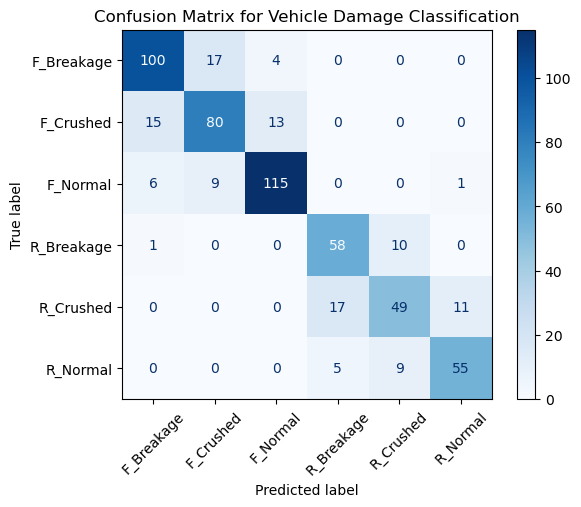

In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [34]:
torch.save(model.state_dict(), 'saved_model.pth')